# Imports

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import statsmodels.api as sm

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Analyse du dataset

**Charger les données**

In [39]:
data = pd.read_csv('./Data/coffee-prices-historical-data.csv')
print(data.shape)
data.head()

(12542, 2)


,date,value
0,1973-08-20,0.6735
1,1973-08-21,0.6710
2,1973-08-22,0.6580
3,1973-08-23,0.6675
4,1973-08-24,0.6660


**Nettoyage**

In [ ]:
#Valeur nulles ?
data.isnull().sum()
#Pas de valeur nulles

# La colonne date doit être au format datetime
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

# Vérifier les dates manquantes
full_date_range = pd.date_range(start=data['date'].min(), end=data['date'].max(), freq='D')
missing_dates = full_date_range.difference(data['date'])

# Afficher les dates manquantes
if len(missing_dates) > 0:
    print("Dates manquantes :")
    print(missing_dates)
    
    # Ajouter les dates manquantes avec des valeurs NaN
    missing_df = pd.DataFrame({'date': missing_dates, 'value': np.nan})
    data = pd.concat([data, missing_df]).sort_values(by='date').reset_index(drop=True)
    
    # Remplacer les valeurs manquantes par interpolation linéaire
    data['value'] = data['value'].interpolate(method='linear')
    
    print("Les dates manquantes ont été remplacées par interpolation linéaire.")
else:
    print("Aucune date manquante.")

# Vérification finale
data.describe()

Aucune date manquante.


,date,value
count,18247,18247.000000
mean,1998-08-12 00:00:00,1.287730
min,1973-08-20 00:00:00,0.425000
25%,1986-02-14 12:00:00,0.958000
50%,1998-08-12 00:00:00,1.247500
75%,2011-02-06 12:00:00,1.509000
max,2023-08-04 00:00:00,3.356300
std,NaN,0.490116


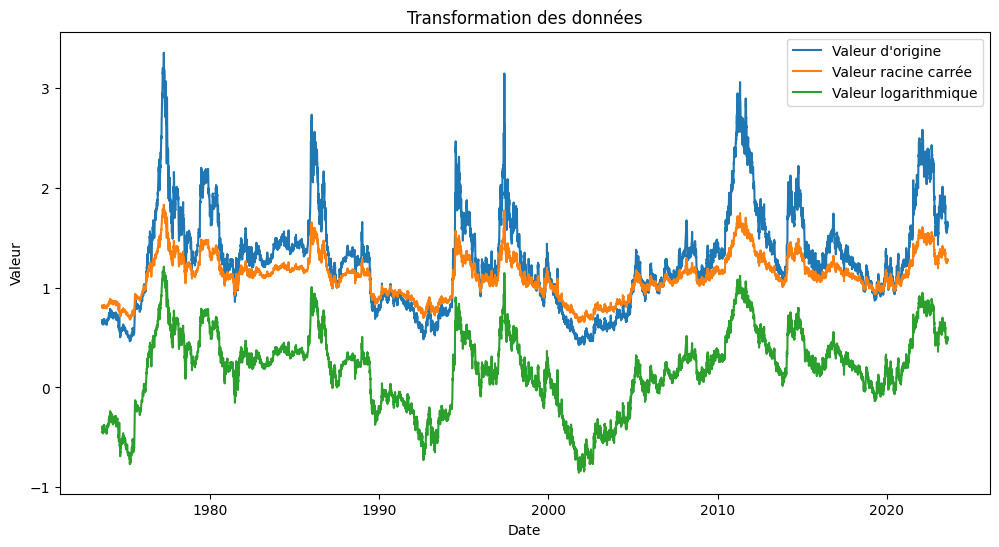

In [ ]:
data['value_sqrt'] = np.sqrt(data['value'])
data['value_log'] = np.log(data['value'])

plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['value'], label='Valeur d\'origine')
plt.plot(data['date'], data['value_sqrt'], label='Valeur racine carrée')
plt.plot(data['date'], data['value_log'], label='Valeur logarithmique')
plt.title('Transformation des données')
plt.xlabel('Date')
plt.ylabel('Valeur')
plt.legend()
plt.show()

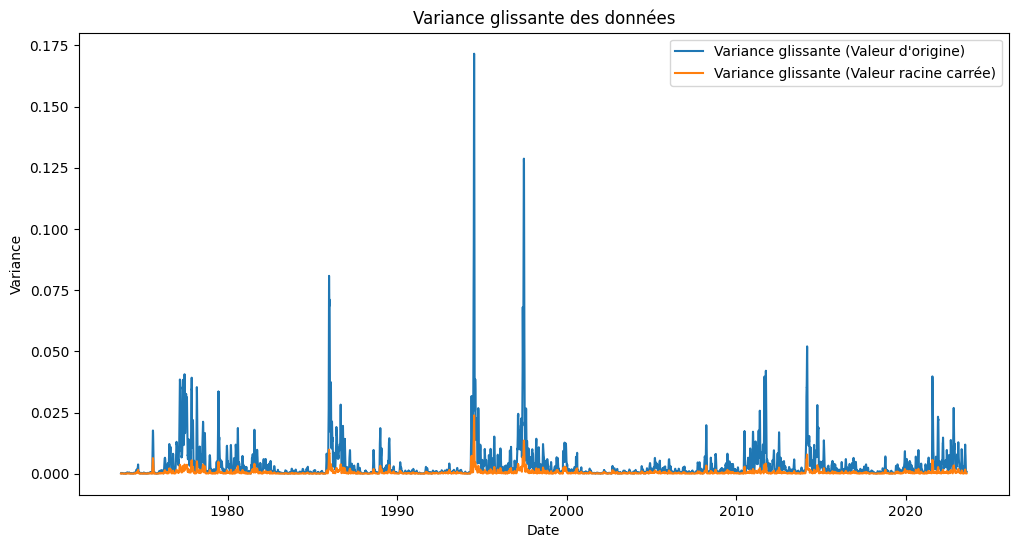

In [59]:
# Variance glissante
window_size = 30  # Taille de la fenêtre glissante
rolling_variance = data['value'].rolling(window=window_size).var()
rolling_variance_sqrt = data['value_sqrt'].rolling(window=window_size).var()
rolling_variance_log = data['value_log'].rolling(window=window_size).var()

plt.figure(figsize=(12, 6))
plt.plot(data['date'], rolling_variance, label='Variance glissante (Valeur d\'origine)')
plt.plot(data['date'], rolling_variance_sqrt, label='Variance glissante (Valeur racine carrée)')
#plt.plot(data['date'], rolling_variance_log, label='Variance glissante (Valeur logarithmique)')
plt.title('Variance glissante des données')
plt.xlabel('Date')
plt.ylabel('Variance')
plt.legend()
plt.show()

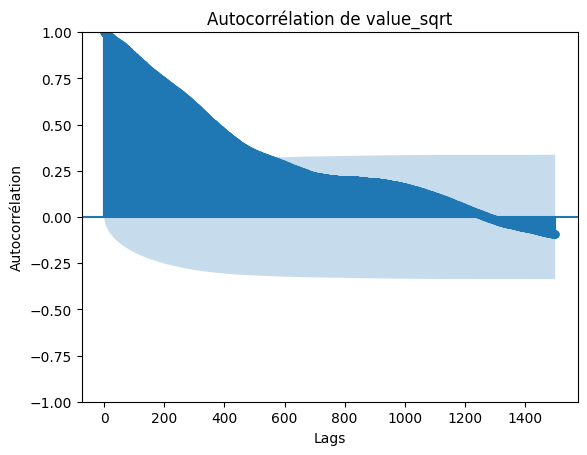

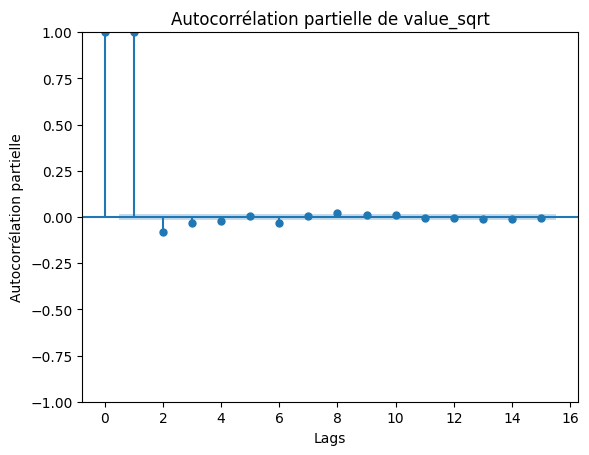

In [65]:
#Autocvariance de value_sqrt
plot_acf(data['value_sqrt'], lags=1500)
plt.title('Autocorrélation de value_sqrt')
plt.xlabel('Lags')
plt.ylabel('Autocorrélation')
plt.show()

# Autcorélation partielle de value_sqrt
plot_pacf(data['value_sqrt'], lags=15)
plt.title('Autocorrélation partielle de value_sqrt')
plt.xlabel('Lags')
plt.ylabel('Autocorrélation partielle')
plt.show()

Statistique ADF: -22.439877765420032
p-value: 0.0
La série est stationnaire


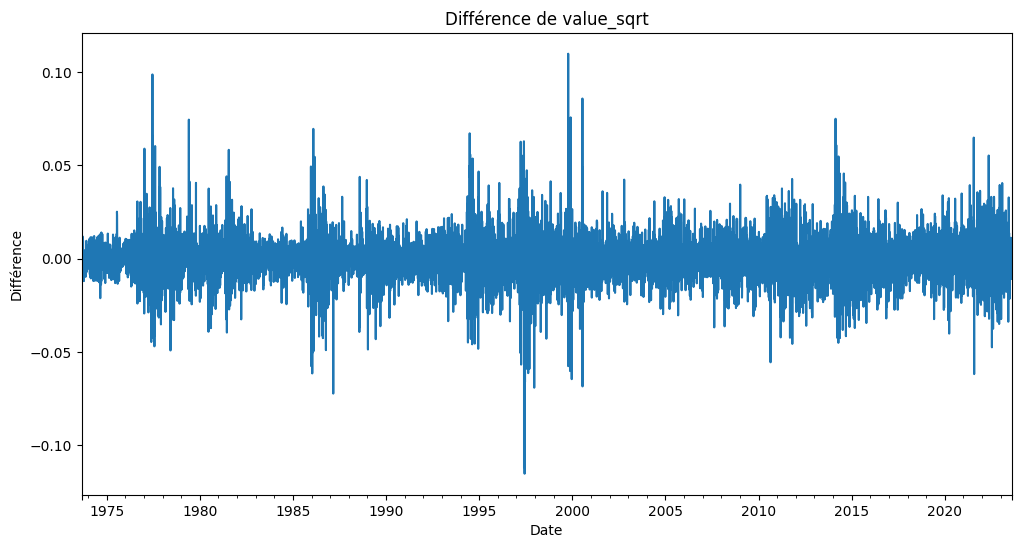

In [ ]:
# On s'intéresse à la série temporelle value_sqrt_diff
data['value_sqrt_diff'] = data['value_sqrt'].diff()
# On supprime la première ligne qui contient NaN
data.dropna(inplace=True)
# On vérifie la stationnarité de value_sqrt_diff
result = adfuller(data['value_sqrt_diff'])
print('Statistique ADF:', result[0])
print('p-value:', result[1])
if result[1] < 0.05:
    print("La série est stationnaire")
else:
    print("La série n'est pas stationnaire")


data['value_sqrt_diff'].plot(figsize=(12, 6))
plt.title('Différence de value_sqrt')
plt.xlabel('Date')
plt.ylabel('Différence')
plt.show()

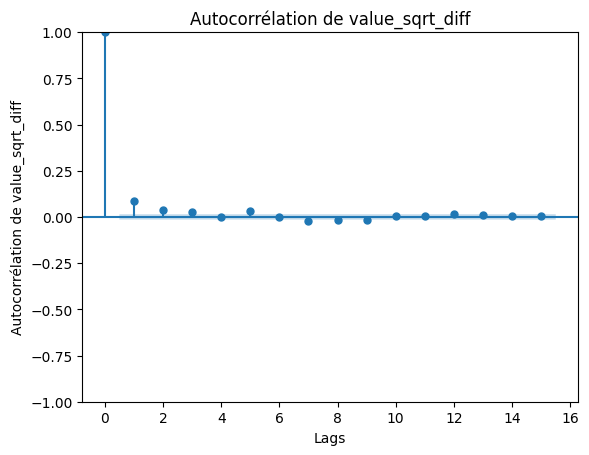

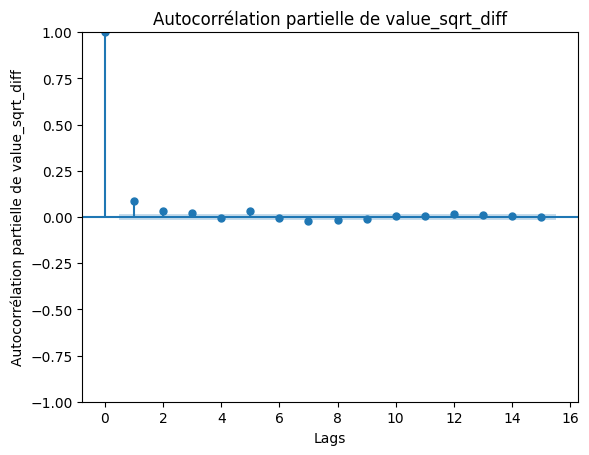

In [ ]:
# Autocorrélation de value_sqrt_diff
plot_acf(data['value_sqrt_diff'], lags=15)
plt.title('Autocorrélation de value_sqrt_diff')
plt.xlabel('Lags')
plt.ylabel('Autocorrélation de value_sqrt_diff')
plt.show()

# Autocorrélation partielle de value_sqrt_diff
plot_pacf(data['value_sqrt_diff'], lags=15)
plt.title('Autocorrélation partielle de value_sqrt_diff')
plt.xlabel('Lags')
plt.ylabel('Autocorrélation partielle de value_sqrt_diff')
plt.show()

In [ ]:
# Split train/test
T = len(data)
train_size = int(0.99 * T)  # 99% train
data_train = data.iloc[:train_size]
data_test = data.iloc[train_size:]


# Ajustement du modèle ARIMA
model = sm.tsa.ARIMA(data_train['value_sqrt_diff'], order=(1, 0, 1))
model_fit = model.fit()

# Prédictions sur l'ensemble de test
predictions = model_fit.forecast(steps=len(data_test))
print(f"predictions : {predictions.shape}")
print(f"data_test : {data_test.shape}")



predictions : (183,)
data_test : (183, 5)


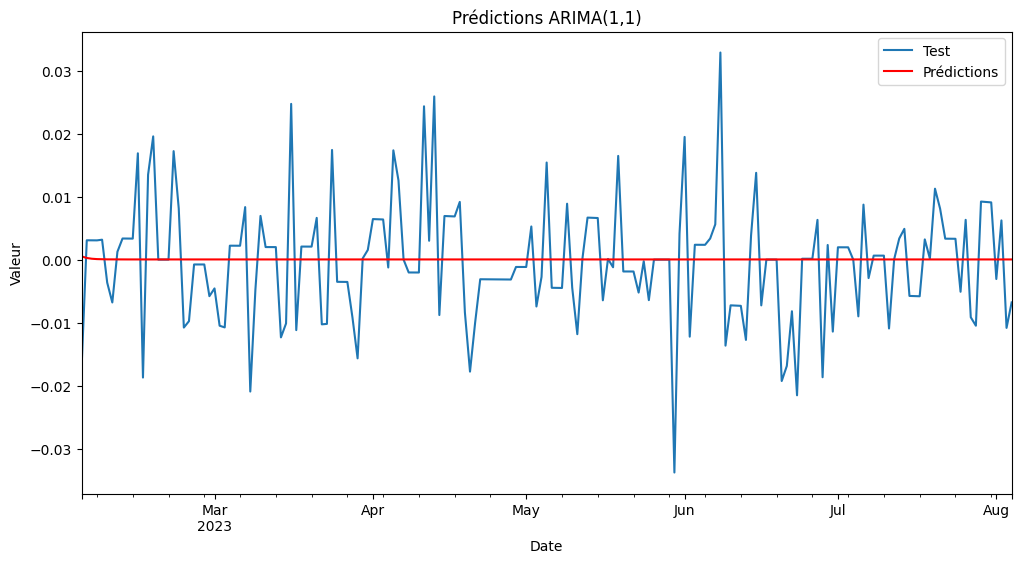

In [102]:
# Calcul des erreurs
mse_value = mse(data_test['value'], predictions)

#graphique prédictions
plt.figure(figsize=(12, 6))
data_test['value_sqrt_diff'].plot( label='Test')
predictions.plot( label='Prédictions', color='red')
plt.title('Prédictions ARIMA(1,1)')
plt.xlabel('Date')
plt.ylabel('Valeur')
plt.legend()
plt.show()

**Plot de la serie**

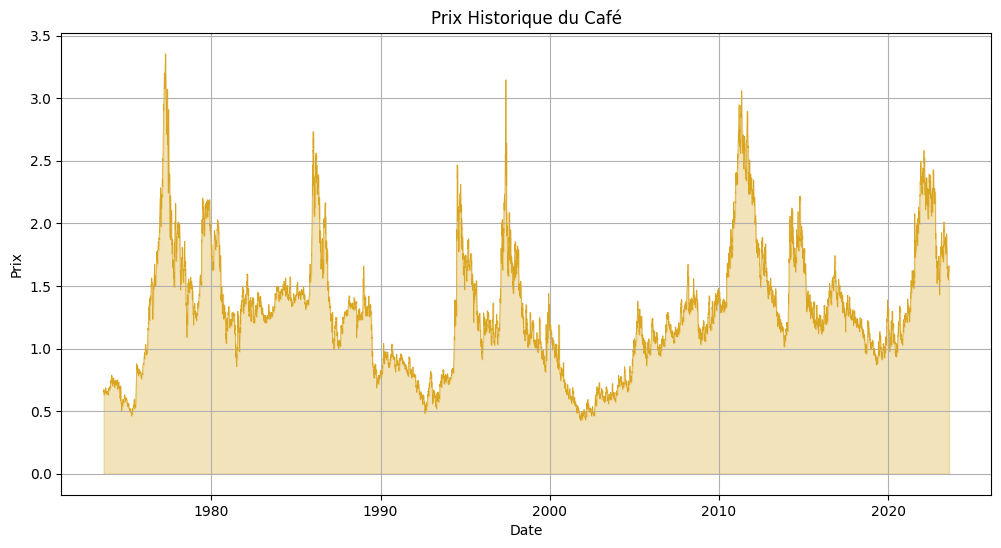

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['value'] , color='goldenrod', linewidth=0.5)
plt.fill_between(date, coffe_price, color='goldenrod', alpha=0.3)
plt.title('Prix Historique du Café')
plt.xlabel('Date')
plt.ylabel('Prix')
plt.grid(True)
plt.show()

In [46]:
data['value'].describe()

count    18247.000000
mean         1.287730
std          0.490116
min          0.425000
25%          0.958000
50%          1.247500
75%          1.509000
max          3.356300
Name: value, dtype: float64

# 2. Analyse de la série P_t ? 
$$
\text{ On pose }P_t = \text{ Coffe price à l'instant t}
$$

**Conclusions** :Les résultats de l'autocovariance sont étranges, et nous pousse à étudier X_t

## a) Test ADF pour P_t
On peut faire le test ADF avec statsmodels :


Si la p-value est inférieure à un seuil (ex. 0.05), on rejette l’hypothèse nulle de non-stationnarité → la série est considérée comme stationnaire.

Si la p-value est élevée, la série est probablement non stationnaire, et on doit la stationnariser.

**Cet indicateur semble nous affirmer que la série est stationnaire.**

In [47]:
result = adfuller(data['value'], autolag='AIC')
adf_stat = result[0]
p_value = result[1]

print(f"ADF Statistic: {adf_stat}")
print(f"p-value: {p_value}")
if result[1] < 0.05:
    print("La série est stationnaire (p-value < 0.05).")
else:
    print("La série n'est pas stationnaire (p-value >= 0.05).")


ADF Statistic: -3.519514922723841
p-value: 0.007499827950267166
La série est stationnaire (p-value < 0.05).


## b) Analyse espérance de P_t

$$
\exists \: m \: / \: E[P_t] = m \: , \: \forall \: t \: ?
$$

**L'analyse semble OK, sans plus**

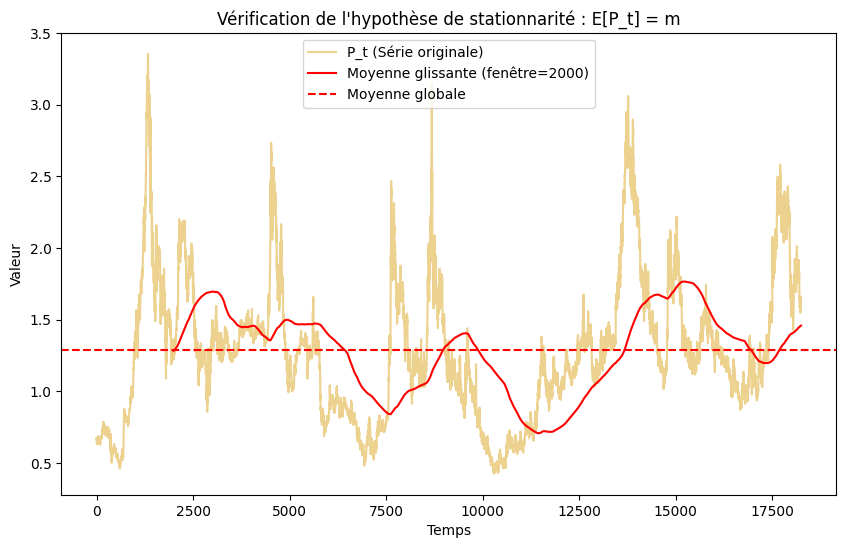

In [48]:
# Calcul de la moyenne glissante sur une fenêtre
window_size = 2000
rolling_mean = data['value'].rolling(window=window_size).mean()
P_t_mean = rolling_mean.mean()

# Vérification de la stationnarité
plt.figure(figsize=(10, 6))
plt.plot(data['value'], label='P_t (Série originale)', c='goldenrod', alpha=0.5)
plt.plot(rolling_mean, label=f'Moyenne glissante (fenêtre={window_size})', color='red')
plt.axhline(data['value'].mean(), color='red', linestyle='dashed', label="Moyenne globale")

plt.title("Vérification de l'hypothèse de stationnarité : E[P_t] = m")
plt.xlabel('Temps')
plt.ylabel('Valeur')
plt.legend()
plt.show()


## c) Analyse autocovariance de P_t

$$ \gamma (t,t+h) = \gamma(h) \: \forall \: t \: ? $$

**On observe bien que l'autocovariance ne dépend pas de t, mais la décroissance faible en h indique un PROBLEME (pas exponentielle)**

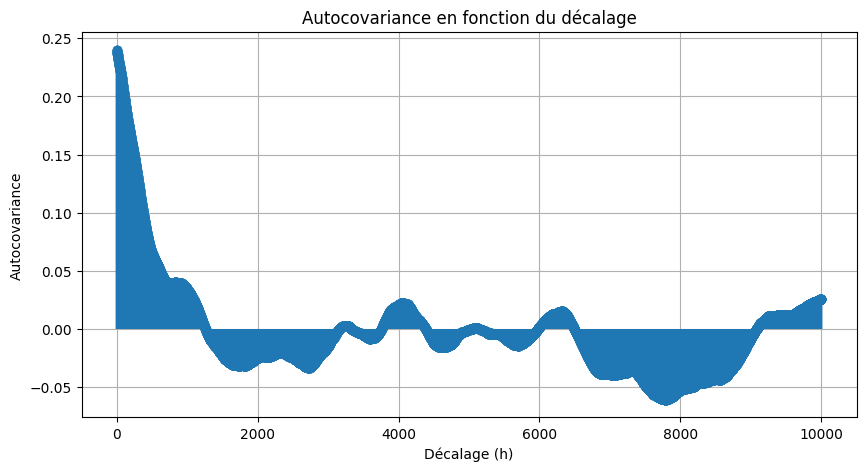

In [50]:
h = 10000

# Calcul de l'autocorrélation pour différents décalages (lags)
autocorr_values = acf(data['value'], nlags=h)

# Calcul de l'autocovariance
variance = np.var(data['value'], ddof=0)  # Variance de la série
autocov_values = autocorr_values * variance  # Autocovariance = Autocorrélation * Variance

# Tracer l'autocovariance
plt.figure(figsize=(10, 5))
plt.stem(range(h+1), autocov_values, basefmt=" ")
plt.xlabel('Décalage (h)')
plt.ylabel('Autocovariance')
plt.title('Autocovariance en fonction du décalage')
plt.grid(True)
plt.show()

### Annexe : variance glissante de P_t

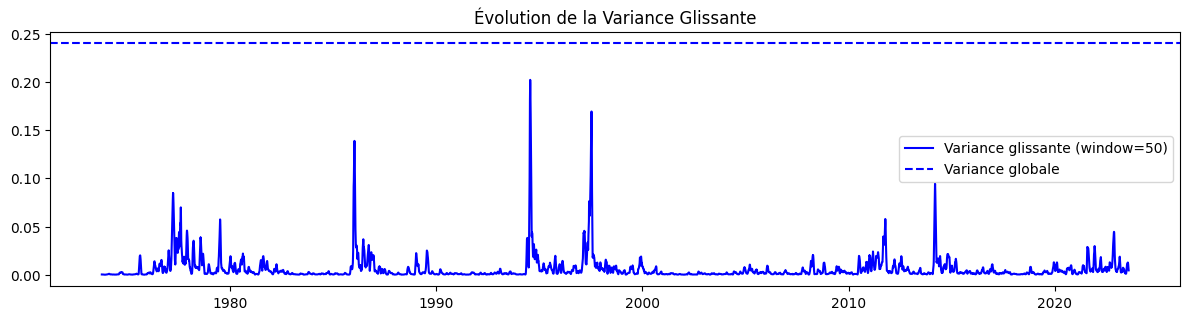

In [51]:
h = 50

# Vérification de la variance constante (variance glissante)
rolling_var = data['value'].rolling(window=h).var()

# Tracer les résultats
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 2)
plt.plot(data['date'], rolling_var, label=f"Variance glissante (window={h})", color='blue')
plt.axhline(data['value'].var(), color='blue', linestyle='dashed', label="Variance globale")
plt.title("Évolution de la Variance Glissante")
plt.legend()

plt.tight_layout()
plt.show()

## d) Modélisation ARMA(p,q) de P_t ?

**Ici hypothèse :**

$$P_t = \sum_{k=1}^{p} \phi_k P_{t-k} + \sum_{k=1}^{q} \theta_k Z_{t-k} + Z_t \quad : \quad Z_t \: \text{est un Bruit Blanc}$$

## e) Choix d’un ARMA ou ARIMA ? **--> ARMA OBLIGATOIRE car seul modèle vu en cours**


- ARMA(p,q) : on l’emploie si la série est déjà stationnaire. 
- ARIMA(p,d,q) : si ta série ne l’est pas, tu peux prendre en compte la différenciation (d=1) directement dans le modèle.

- ARIMA(p,1,q) équivaut plus ou moins à ARMA(p,q) appliqué à la série différenciée.

## f) Identification des paramètres p, q --> **AR(1)**
Pour choisir p et q, on observe souvent :

- **La ACF (Autocorrelation Function) aide à déterminer q pour MA.**
- **La PACF (Partial Autocorrelation Function) aide à déterminer p pour AR.**

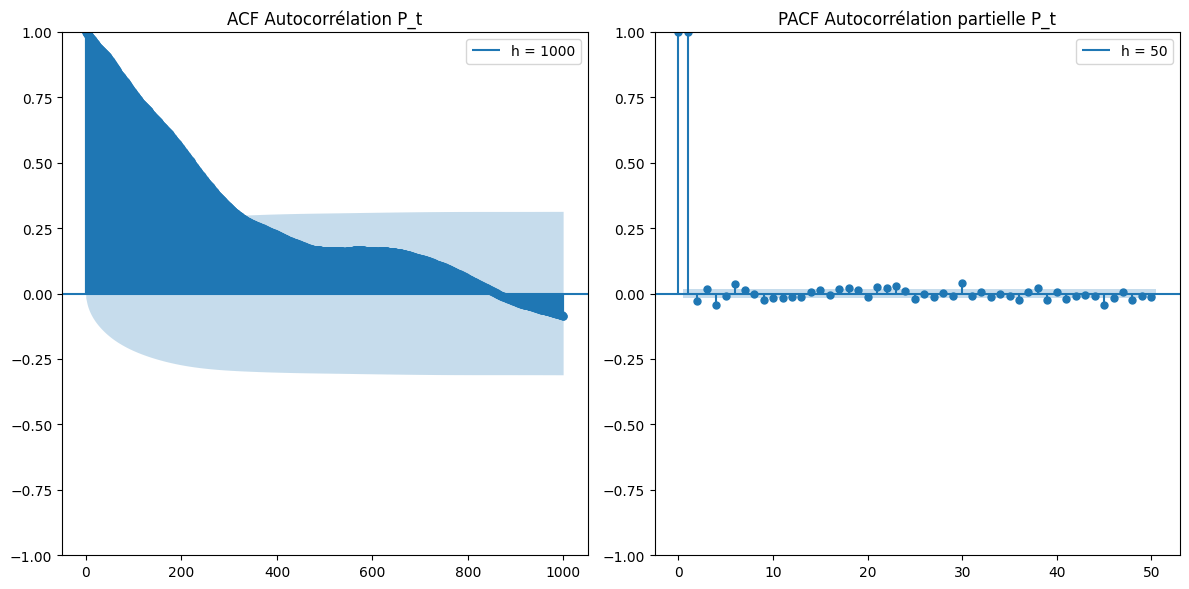

In [11]:
# P_t pour ACF et PACF
h = 1000
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plot_acf(data['value'], lags=h, ax=plt.gca())
plt.title('ACF Autocorrélation P_t')
plt.legend([f'h = {h}'])

h=50
plt.subplot(1, 2, 2)
plot_pacf(data['value'], lags=h, ax=plt.gca())
plt.title('PACF Autocorrélation partielle P_t')
plt.legend([f'h = {h}'])

plt.tight_layout()
plt.show()

Pas de décrochage d'ACF et Décrochage PACF a h = 1 ==> AR(1)

# 3. Analyse de la série X_t = P_t - P_t-1
Puisque gamme_Pt ne décroit pas exponentiellement, on tente X_t

$$
\text{ On pose }X_t  = \Delta(P_t) = P_t - P_{t-1}$$

**Conclusion** : On va faire l'hypothèse que $ X \sim \mathcal{N}(0,\sigma^2)$
​

## Création et analyse rapide X_t

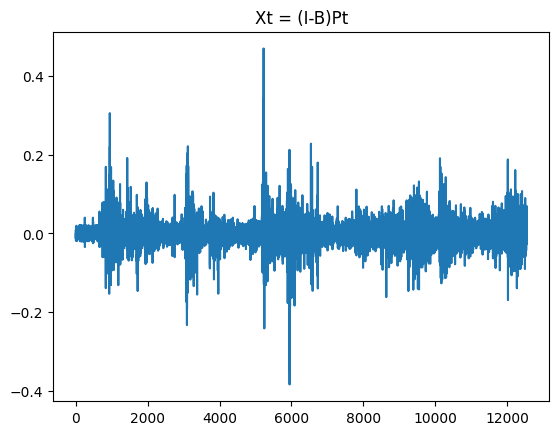

In [12]:
# Calcul de X_t = P_t - P(t-1)
data['value_diff'] = data['value'].diff()

# Suppression des NaN et des valeurs infinies
data = data.dropna(subset=['value_diff'])  # Supprime les lignes avec NaN dans 'value_diff'

# Visualisation
plt.figure()
plt.plot(data['value_diff'])
plt.title("Xt = (I-B)Pt")
plt.show()

In [13]:
# Test ADF
result = adfuller(data['value_diff'], autolag='AIC')
adf_stat = result[0]
p_value = result[1]

print(f"ADF Statistic: {adf_stat}")
print(f"p-value: {p_value}")

data['value_diff'].describe()

ADF Statistic: -18.12298147642022
p-value: 2.5185120309214923e-30


count    12541.000000
mean         0.000075
std          0.031635
min         -0.384000
25%         -0.013000
50%          0.000000
75%          0.013500
max          0.470000
Name: value_diff, dtype: float64

## a) Test ADF pour X_t

**Cet indicateur semble nous affirmer que la série est stationnaire.**

On peut faire le test ADF avec statsmodels :


Si la p-value est inférieure à un seuil (ex. 0.05), on rejette l’hypothèse nulle de non-stationnarité → la série est considérée comme stationnaire.

Si la p-value est élevée, la série est probablement non stationnaire, et on doit la stationnariser.


In [14]:
result = adfuller(data['value_diff'], autolag='AIC')
adf_stat = result[0]
p_value = result[1]

print(f"ADF Statistic: {adf_stat}")
print(f"p-value: {p_value}")
if result[1] < 0.05:
    print("La série est stationnaire (p-value < 0.05).")
else:
    print("La série n'est pas stationnaire (p-value >= 0.05).")


ADF Statistic: -18.12298147642022
p-value: 2.5185120309214923e-30
La série est stationnaire (p-value < 0.05).


## b) Analyse espérance de X_t

$$
\exists \: m \: / \: E[X_t] = m \: , \: \forall \: t \: ?
$$

**tout porte à croire que la Série est centrée --> C'est un bon point**

Moyenne de X_t : 7.771943823811045e-05


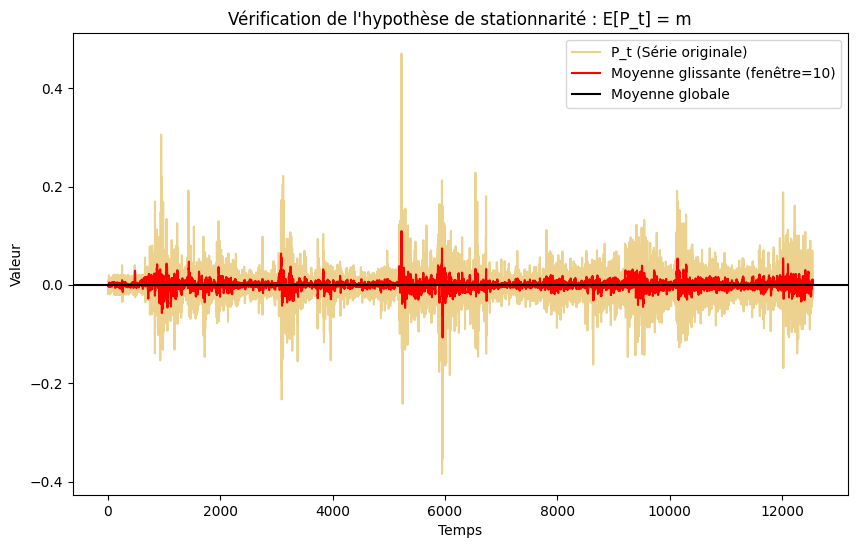

In [15]:
# Calcul de la moyenne glissante sur une fenêtre
window_size = 10
rolling_mean = data['value_diff'].rolling(window=window_size).mean()
X_t_mean = rolling_mean.mean()

print(f"Moyenne de X_t : {X_t_mean}")

# Vérification de la stationnarité
plt.figure(figsize=(10, 6))
plt.plot(data['value_diff'], label='P_t (Série originale)', c='goldenrod', alpha=0.5)
plt.plot(rolling_mean, label=f'Moyenne glissante (fenêtre={window_size})', color='red')
plt.axhline(data['value_diff'].mean(), color='black', linestyle='-', label="Moyenne globale")

plt.title("Vérification de l'hypothèse de stationnarité : E[P_t] = m")
plt.xlabel('Temps')
plt.ylabel('Valeur')
plt.legend()
plt.show()


**Calculs formels:**

- $$ \text{Si nous avions} \: E[P_t] = m \:\: \text{alors} \:\: E[X_t] = E[P_t] - E[P_{t-1}] = 0$$

- $$ \text{Ici} \quad \hat{X_n} = \frac{1}{n} \sum X_i \approx 0 $$

- De plus la moyenne glissante est stable, même avec une petite fenêtre (10)

## c) Analyse autocovariance de X_t

$$ \gamma_X (t,t+h) = \gamma_X(h) \: \forall \: t \: ? $$

**Une variance très faible et une covariance nulle --> X_t un bruit blanc ou un MA(0) ?**

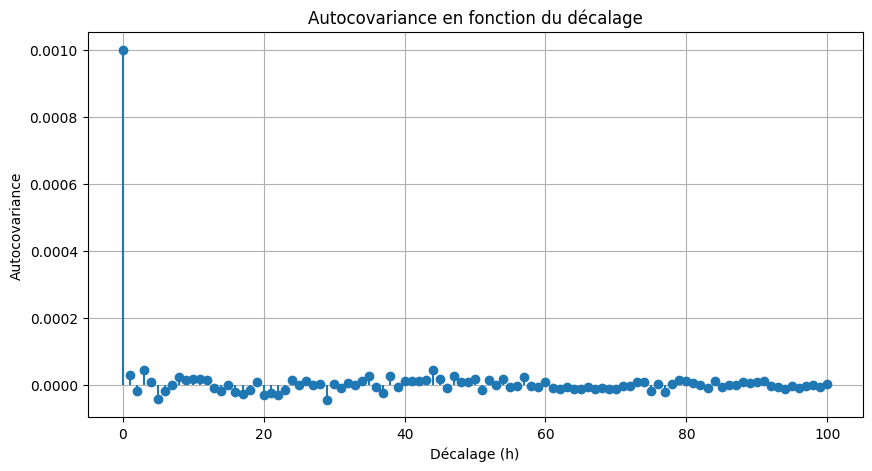

In [16]:
h = 100

# Calcul de l'autocorrélation pour différents décalages (lags)
autocorr_values = acf(data['value_diff'], nlags=h)

# Calcul de l'autocovariance
variance = np.var(data['value_diff'], ddof=0)  # Variance de la série
autocov_values = autocorr_values * variance  # Autocovariance = Autocorrélation * Variance

# Tracer l'autocovariance
plt.figure(figsize=(10, 5))
plt.stem(range(h+1), autocov_values, basefmt=" ")
plt.xlabel('Décalage (h)')
plt.ylabel('Autocovariance')
plt.title('Autocovariance en fonction du décalage')
plt.grid(True)
plt.show()

**Le graphe que l'autocovariance ne dépend pas de t, et est quasiment nulle, sauf pour gamma(0) = sigma = 0.001**


**On observe :**
$$ \forall h > 0 , \quad \gamma_X (t,t+h) \approx 0 $$ 


**Calculs:**
$$ \gamma_X (t,t+h) = Cov(X_t,X_{t+h})  $$
$$ \gamma_X (t,t+h) = Cov(P_t - P_{t-1},P_{t+h} - P_{t+h-1})  $$
$$ \gamma_X (t,t+h) = Cov(P_t,P_{t+h}) + Cov(P_{t-1},P_{t+h-1}) - Cov(P_{t-1},P_{t+h}) - Cov(P_t,P_{t+h-1})  $$

Dans l'hypothèse, (semblant vraie selon l'analyse de P_t) :
$$ \gamma_P (t,t+h) = \gamma_P(h) \: \forall \: t $$

On obtient :
$$ \gamma_X (t,t+h) =  2 \gamma_P(h) - 2\gamma_P(h-1) $$

Hors nous avons vu dans l'analyse de P_t:
$$ \forall h > 0 , \quad \gamma_P(h) \approx \gamma_P(h-1) \quad \text{(i.e. très légère décroissance)}$$ 
$$ \Rightarrow  \forall h > 0 , \quad \gamma_X (t,t+h) = \gamma_X(h) \approx 0 $$ 

Donc nos calculs sont cohérents avec ce que l'on observe

## d) Modélisation ARMA(p,q) de X_t ?

**Ici hypothèse :**

$$X_t = \sum_{k=1}^{p} \phi_k X_{t-k} + \sum_{k=1}^{q} \theta_k Z_{t-k} + Z_t \quad : \quad Z_t \: \text{est un Bruit Blanc}$$

## e) Identification des paramètres p, q
Pour choisir p et q, on observe souvent :

- La ACF (Autocorrelation Function) aide à déterminer q pour MA.
- La PACF (Partial Autocorrelation Function) aide à déterminer p pour AR.

**L'analyse des graphes semblent indiquer un ARMA(0,0) = BB(0,sigma)**

De plus l'histogramme de X_t appuie l'hypothèse de X_t BB 

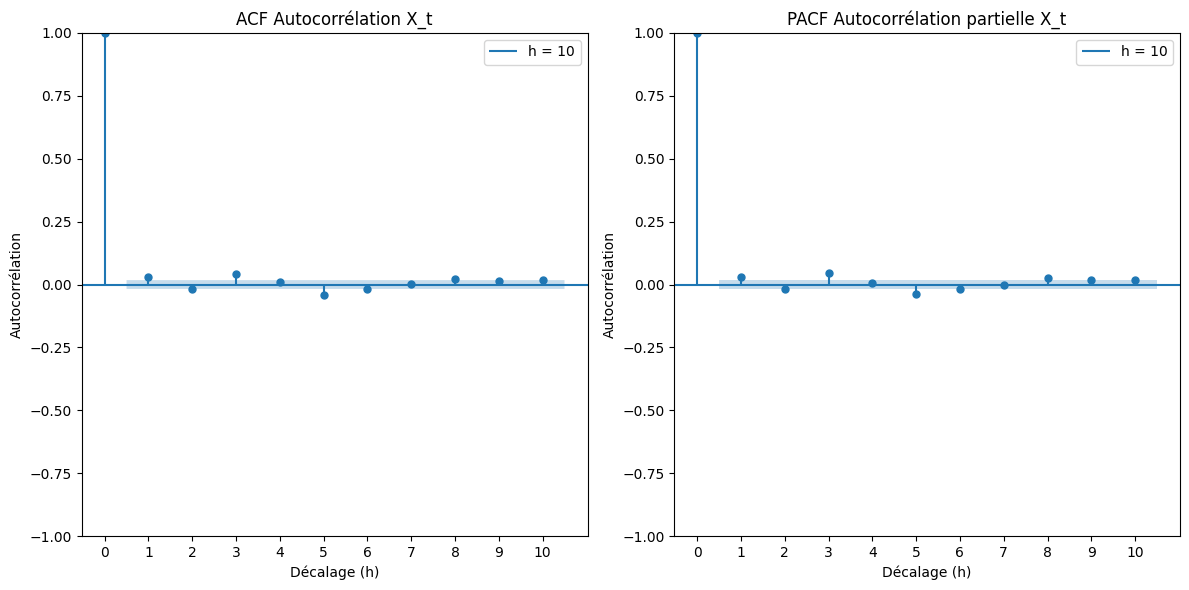

In [17]:
# X_t pour ACF et PACF
h = 10
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plot_acf(data['value_diff'], lags=h, ax=plt.gca())
plt.xticks(ticks=range(h + 1))  # Affiche toutes les unités sur l'axe des abscisses
plt.xlabel('Décalage (h)')
plt.ylabel('Autocorrélation')
plt.title('ACF Autocorrélation X_t')
plt.legend([f'h = {h}'])

plt.subplot(1, 2, 2)
plot_pacf(data['value_diff'], lags=h, ax=plt.gca())
plt.xticks(ticks=range(h + 1))  # Affiche toutes les unités sur l'axe des abscisses
plt.xlabel('Décalage (h)')
plt.ylabel('Autocorrélation')
plt.title('PACF Autocorrélation partielle X_t')
plt.legend([f'h = {h}'])

plt.tight_layout()
plt.show()

Décrochage ACF et PACF à h= 0

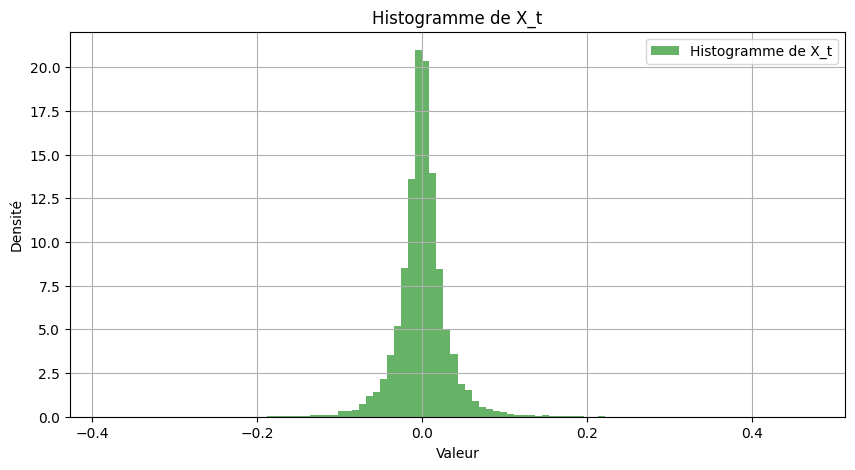

In [18]:
#Tracer histogramme de X_t = data['value_diff']
plt.figure(figsize=(10, 5))
plt.hist(data['value_diff'], bins=100, density=True, alpha=0.6, color='g', label='Histogramme de X_t')
plt.title("Histogramme de X_t")
plt.xlabel("Valeur")
plt.ylabel("Densité")
plt.legend()
plt.grid(True)
plt.show()

## f) Conséquences de X_t ~ BB(0,Sigma)
Ca pose problème, mais on va supposer 
**HYPOTHESE LA PLUS PROBABLE :**
$$P_t = \phi P_{t-1} + X_t \: \text{où} \quad [ \phi \approx 1 \: et \: \phi < 1 ] $$
$$ \Rightarrow P_t \sim AR(1) $$

Après analyse, il semblerait que :
$$X_t \sim ARMA(0,0) = BB(0,\sigma)$$

Supposons vraie cette hypothèse, alors :

$$X_t = P_t - P_{t-1} \sim BB(0,\sigma)$$
$$ \Rightarrow P_t = P_{t-1} + X_t $$
$$ \Rightarrow P_t \sim AR(1) \quad \text{MAIS avec} \quad \phi_1 = 1 $$

Cela pose un problème, en effet :
$$ \phi_1 = 1 \quad \Rightarrow \quad P_t = \sum_{k=0}^{\infty} X_{t-k} $$

Cela implique que **P_t est une série dont la variance augmente avec le temps**, car la somme cumulative d'un bruit blanc.
Donc dans ce cas **P_t n'est pas stationnaire.**

Mais cela n'est pas cohérent avec ce que nous avons observé de P_t (sa variance n'augmente pas avec le temps, et elle semble stationnaire)

**HYPOTHESE LA PLUS PROBABLE :**
$$P_t = \phi P_{t-1} + X_t \: \text{où} \quad [ \phi \approx 1 \: et \: \phi < 1 ] $$

# 4. Analyse de la série $\tilde{P}_t = P_t - \hat{m}_P$
**Conclusion, on suppose :**
- $$ \tilde{P}_t \: \text{est stationnaire} $$
- $$ \tilde{P}_t = \phi \tilde{P}_{t-1} + Z_t \:\quad \text{où} \quad [ \phi \approx 0.9.. <1 ] \quad, \quad Z_t \sim BB(0,\sigma) $$

**On va surement faire également l'hypothèse que** $ Z \sim \mathcal{N}(0,\sigma) $

Puisque P_t ~ AR(1), on a $$ E[P_t] = \mu / \phi = m_p \quad \text{or} \quad \phi \approx 1 \quad \text{donc} \quad \mu \approx m_p $$
Posons 
$$ \tilde{m_P} = 1/T \: \sum_{t=1}^{T} P_t $$
$$ \tilde{P}_t = P_t - \tilde{m_P} $$
$$ \Rightarrow E[\tilde{P}_t] \approx 0 $$

## Création et analyse rapide P~_t

count    1.254100e+04
mean     5.439128e-17
std      4.902275e-01
min     -8.648219e-01
25%     -3.293219e-01
50%     -4.132187e-02
75%      2.201781e-01
max      2.066478e+00
Name: value_cent, dtype: float64


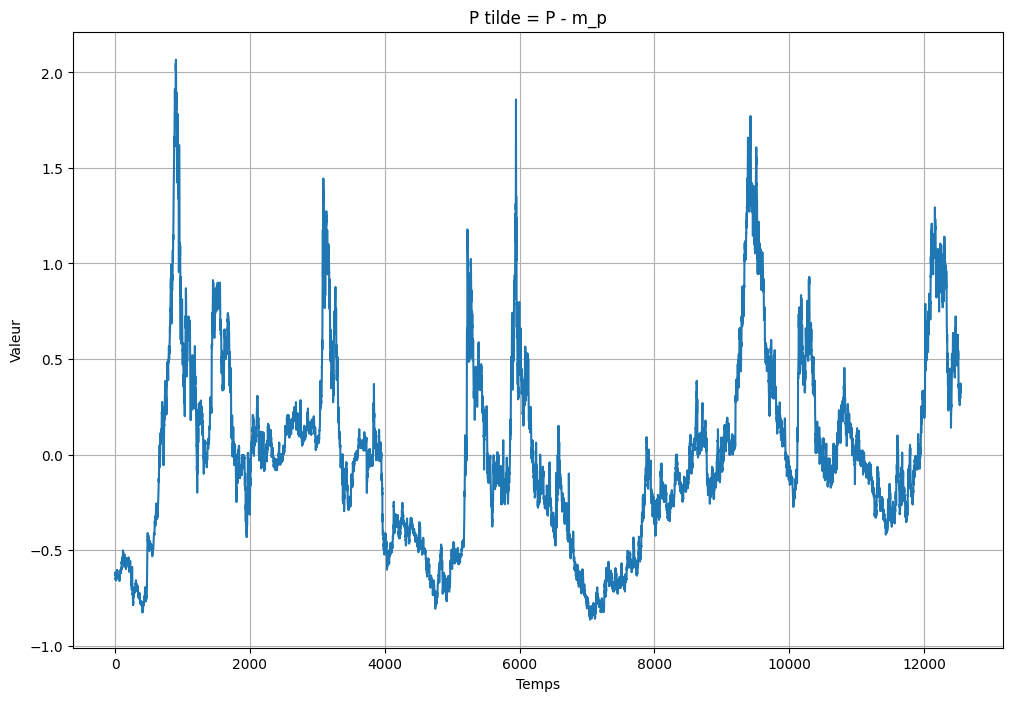

In [19]:
# Calcul de Ptilde = p_t - m_p
data['value_cent'] = data['value'] - data['value'].mean()
# Suppression des NaN et des valeurs infinies  # Supprime les lignes avec NaN dans 'value_diff'
data = data.dropna(subset=['value_cent'])  # Supprime les lignes avec NaN dans 'value_diff'


print(data['value_cent'].describe())
# Visualisation
plt.figure(figsize=(12,8))
plt.plot(data['value_cent'])
plt.title("P tilde = P - m_p")
plt.xlabel('Temps')
plt.ylabel('Valeur')
plt.grid(True)
plt.show()



## a) Test ADF pour tilde P_t
On peut faire le test ADF avec statsmodels :


Si la p-value est inférieure à un seuil (ex. 0.05), on rejette l’hypothèse nulle de non-stationnarité → la série est considérée comme stationnaire.

Si la p-value est élevée, la série est probablement non stationnaire, et on doit la stationnariser.

**Cet indicateur semble nous affirmer que la série est stationnaire.**

In [20]:
result = adfuller(data['value_cent'], autolag='AIC')
adf_stat = result[0]
p_value = result[1]


print(f"ADF Statistic: {adf_stat}")
print(f"p-value: {p_value}")
if result[1] < 0.05:
    print("La série est stationnaire (p-value < 0.05).")
else:
    print("La série n'est pas stationnaire (p-value >= 0.05).")


ADF Statistic: -3.642427811092353
p-value: 0.004999824956867079
La série est stationnaire (p-value < 0.05).


## b) Analyse espérance de tilde P_t

$$
\exists \: m \: / \: E[\tilde{P_t}] = m \: , \: \forall \: t \: ?
$$

**L'analyse semble OK, sans plus**

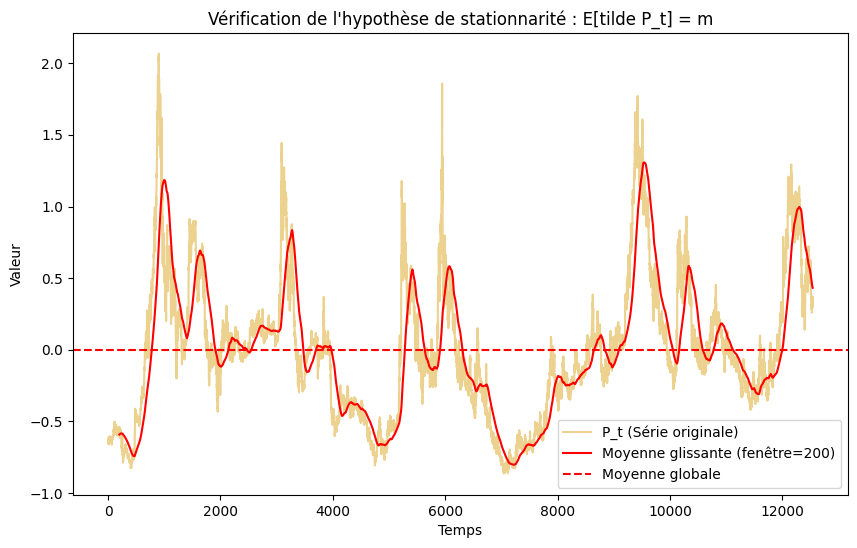

In [21]:
# Calcul de la moyenne glissante sur une fenêtre
window_size = 200
rolling_mean = data['value_cent'].rolling(window=window_size).mean()
P_t_mean = rolling_mean.mean()

# Vérification de la stationnarité
plt.figure(figsize=(10, 6))
plt.plot(data['value_cent'], label='P_t (Série originale)', c='goldenrod', alpha=0.5)
plt.plot(rolling_mean, label=f'Moyenne glissante (fenêtre={window_size})', color='red')
plt.axhline(data['value_cent'].mean(), color='red', linestyle='dashed', label="Moyenne globale")

plt.title("Vérification de l'hypothèse de stationnarité : E[tilde P_t] = m")
plt.xlabel('Temps')
plt.ylabel('Valeur')
plt.legend()
plt.show()


## c) Analyse autocovariance de tilde P_t

$$ \gamma_{\tilde{P}} (t,t+h) = \gamma_{\tilde{P}}(h) \: \forall \: t \: ? $$

**On observe bien que l'autocovariance ne dépend pas de t, la décroissance est faible en h pour h petit, mais si on regarde h grand on a bien un décroissance exponentielle**

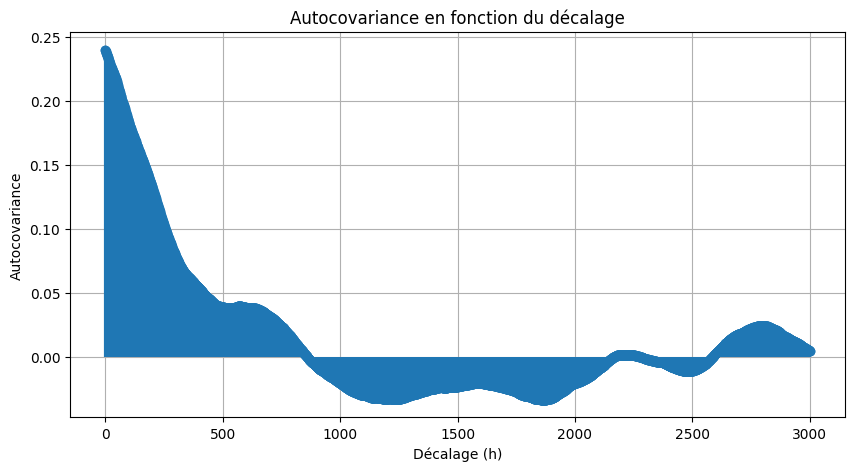

In [22]:
h = 3000

# Calcul de l'autocorrélation pour différents décalages (lags)
autocorr_values = acf(data['value_cent'], nlags=h)

# Calcul de l'autocovariance
variance = np.var(data['value_cent'], ddof=0)  # Variance de la série
autocov_values = autocorr_values * variance  # Autocovariance = Autocorrélation * Variance

# Tracer l'autocovariance
plt.figure(figsize=(10, 5))
plt.stem(range(h+1), autocov_values, basefmt=" ")
plt.xlabel('Décalage (h)')
plt.ylabel('Autocovariance')
plt.title('Autocovariance en fonction du décalage')
plt.grid(True)
plt.show()

### Annexe : variance glissante de P_t

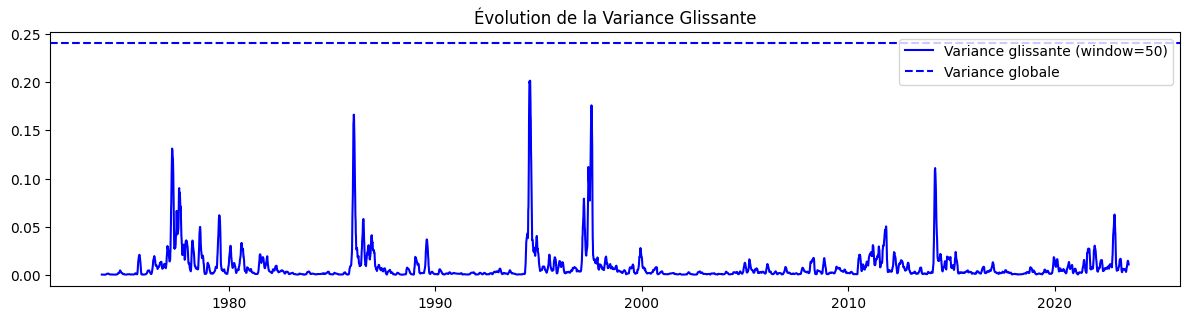

In [23]:
h = 50

# Vérification de la variance constante (variance glissante)
rolling_var = data['value'].rolling(window=h).var()

# Tracer les résultats
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 2)
plt.plot(data['date'], rolling_var, label=f"Variance glissante (window={h})", color='blue')
plt.axhline(data['value'].var(), color='blue', linestyle='dashed', label="Variance globale")
plt.title("Évolution de la Variance Glissante")
plt.legend()

plt.tight_layout()
plt.show()

## d) Modélisation ARMA(p,q) de tilde P_t ?

**Ici hypothèse :**

$$\tilde{P}_t = \sum_{k=1}^{p} \phi_k \tilde{P}_{t-k} + \sum_{k=1}^{q} \theta_k Z_{t-k} + Z_t \quad : \quad Z_t \: \text{est un Bruit Blanc}$$

## e) Choix d’un ARMA ou ARIMA ? **--> ARMA OBLIGATOIRE car seul modèle vu en cours**


- ARMA(p,q) : on l’emploie si la série est déjà stationnaire. 
- ARIMA(p,d,q) : si ta série ne l’est pas, tu peux prendre en compte la différenciation (d=1) directement dans le modèle.

- ARIMA(p,1,q) équivaut plus ou moins à ARMA(p,q) appliqué à la série différenciée.

## f) Identification des paramètres p, q --> **AR(1)**
Pour choisir p et q, on observe souvent :

- **La ACF (Autocorrelation Function) aide à déterminer q pour MA.**
- **La PACF (Partial Autocorrelation Function) aide à déterminer p pour AR.**

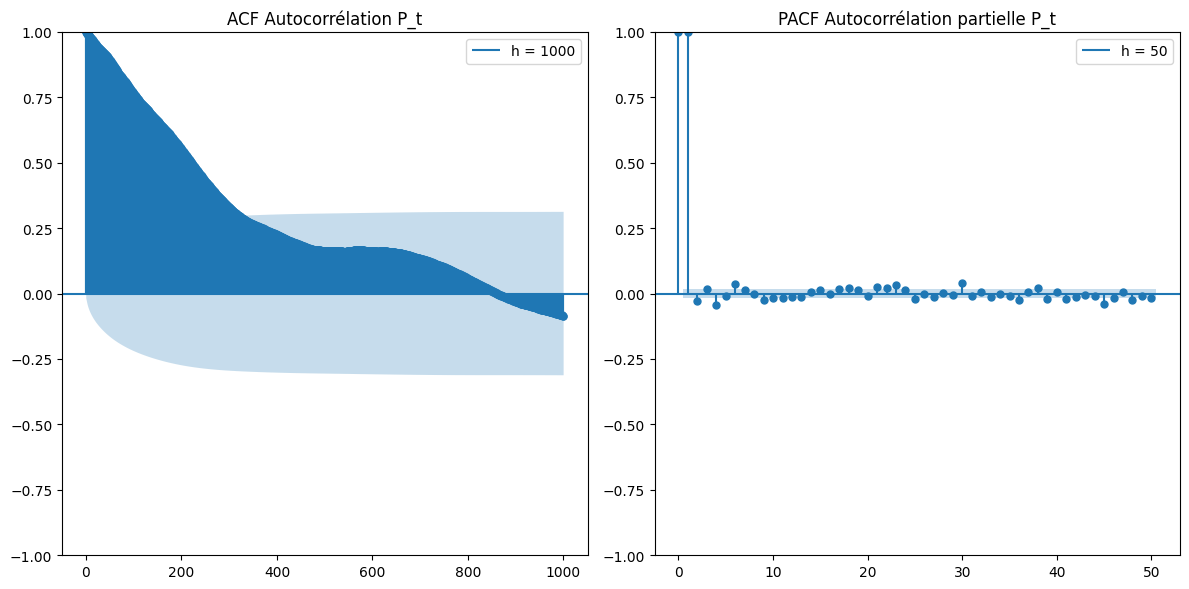

In [24]:
# P_t pour ACF et PACF
h = 1000
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plot_acf(data['value_cent'], lags=h, ax=plt.gca())
plt.title('ACF Autocorrélation P_t')
plt.legend([f'h = {h}'])

h=50
plt.subplot(1, 2, 2)
plot_pacf(data['value_cent'], lags=h, ax=plt.gca())
plt.title('PACF Autocorrélation partielle P_t')
plt.legend([f'h = {h}'])

plt.tight_layout()
plt.show()

Pas de décrochage d'ACF et Décrochage PACF a h = 1 ==> AR(1) ou ARMA(p,1) avec des petits coeffs pour moi MA et un presque 1 pour AR

# 5. Analyse théorique et Estimation des paramètres pour $\tilde{P}$

**Résultats :** 

$\hat{\phi} = 0.99787..$

$\hat{\sigma} = 0.00099..$

Notre prédicteur est nul de ouf

## a) $\textbf{Modèle AR(1) sur la série centrée :}\quad$

$$\widetilde{P}_t =\; \phi \,\widetilde{P}_{t-1} \;+\; Z_t,\quad Z_t \;\sim\; \mathcal{N}\bigl(0,\sigma^2\bigr).$$

$$\widetilde{P}_t = \sum_{k=0}^{\infty} \phi^k Z_{t-k} \quad \text{avec} \: \psi_0 = 1 $$

$ \text{donc paramètre à estimer} = (\phi,\sigma^2)$



## b) $\textbf{Estimateur de }(\phi,\sigma^2)$

- $ \text{Estimateur des moindres carrés de }\phi:$
$$
\quad
\widehat{\phi}
\;=\;
\frac{\displaystyle \sum_{t=2}^{T} \widetilde{P}_t \,\widetilde{P}_{t-1}}
      {\displaystyle \sum_{t=2}^{T} \widetilde{P}_{t-1}^{2}}
\;.
$$

- $\textbf{Estimateur de }\sigma^2:$
$$
\quad
\widehat{\sigma}^2
\;=\;
\frac{1}{T-1}
\sum_{t=2}^{T}
\Bigl(\,\widetilde{P}_t \;-\; \widehat{\phi}\,\widetilde{P}_{t-1}\Bigr)^2.
$$

Fonction d'estimation du paramètre

In [25]:
import numpy as np

def estimate_AR1_params(serie):
    """
    Estime les paramètres d'un modèle AR(1) :
      ptilde[t] = phi * ptilde[t-1] + eps[t],
    avec eps[t] ~ bruit blanc de variance sigma^2.
    
    Paramètres
    ----------
    ptilde : array-like
        Tableau 1D contenant la série centrée : ptilde[t].
        Doit avoir au moins 2 éléments.

    Retour
    ----------
    phi_hat : float
        Estimation du coefficient AR(1).
    sigma_hat_sq : float
        Estimation de la variance du bruit eps[t].
    """

    # Conversion en numpy array si besoin
    serie = np.asarray(serie)
    T = len(serie)
    
    # Vérifications basiques
    if T < 2:
        raise ValueError("La série serie doit contenir au moins 2 points pour estimer un AR(1).")

    # 1) Estimation de phi :
    #    phi_hat = sum_{t=2..T} [ serie[t]*serie[t-1] ] / sum_{t=2..T} [ serie[t-1]^2 ]
    num = 0.0
    den = 0.0
    for t in range(1, T):
        num += serie[t] * serie[t - 1]
        den += serie[t - 1]**2

    phi_hat = num / den

    # 2) Estimation de sigma^2 :
    #    sigma_hat^2 = (1 / (T-1)) * sum_{t=2..T} [ serie[t] - phi_hat * serie[t-1] ]^2
    resid_sum = 0.0
    for t in range(1, T):
        resid_sum += (serie[t] - phi_hat * serie[t - 1])**2

    sigma_hat_sq = resid_sum / (T - 1)
    
    return phi_hat, sigma_hat_sq

phi_hat, sigma_hat_sq = estimate_AR1_params(data['value_cent'])
print(f"phi_hat = {phi_hat}")
print(f"sigma_hat = {sigma_hat_sq}")


phi_hat = 0.9978719574403822
sigma_hat = 0.0009996936238785422


## a) Estimation rho Ptilde

Formule générale :
$$
\hat{\rho}(h) \;=\; 
\frac{
	\frac{1}{T}\displaystyle\sum_{t=1}^{T-h} 
	\bigl(X_{t} - \overline{X}\bigr)\,
	\bigl(X_{t+h} - \overline{X}\bigr)
}{
	\frac{1}{T}\displaystyle\sum_{t=1}^{T}
	\bigl(X_{t} - \overline{X}\bigr)^{2}
}
$$

**Ici on a :**
$$
\hat{\rho_{\tilde{P}}}(h) \;=\; \frac{1}{T}
\frac{
	\displaystyle\sum_{t=1}^{T-h} 
	\tilde{P}_{t} \tilde{P}_{t+h}
}{
	\displaystyle\sum_{t=1}^{T}
	\tilde{P}_{t}^{2}
}
$$



## b) TCL pour la série $\widetilde{P}_t$

Soit $\tilde{P_t}_{t=1,\dots,T}$ notre échantillon.


**TCL pour la moyenne d'une série**
Supposons que la série $\widetilde{P}_t$ satisfasse les conditions habituelles pour un théorème central limite


Alors, lorsque $T\to\infty$, on a 
$$
\sqrt{T}\;\bigl(\,\overline{P} - \mu\bigr) 
\;\;\xrightarrow{d}\;\;
\mathcal{N}(0,\;\sigma^{2}),
$$
où $\mu = \mathbb{E}[P_t]$ est la vraie moyenne de la série (si elle existe) et $\sigma^2$ est la variance asymptotique appropriée.



# 6. Prévision (forecasting)

**Modèle** : 
$\widehat{\widetilde{P}}_{t+1} = \widehat{\phi} \: \widetilde{P}_t.$

Pour simplifier l'écriture, notons $\widehat{Y}_t = \widehat{\widetilde{P}}_t.$ ainsi $\widehat{Y}_{t+1} = \widehat{\phi} \: Y_t$











**Prévision a 1 pas : $\widehat{Y}_{T+1 \mid T}\;=\;\widehat{\phi}\,Y_T.$**


**Prévision à $h$ pas : $ \widehat{Y}_{T+h \mid T}\;=\;\widehat{\phi}^{\,h}\,Y_T$**

## a) Fonction de prédiction

In [26]:
def ar1_forecast(last_observation, phi_hat, steps=1):
    """
    Prévoit P_T+1, ... , P_T+steps 

    forecasts :  Liste [P_{T+1|T}, P_{T+2|T}, ..., P_{T+steps|T}].
    """
    forecasts = []
    current_pred = last_observation
    
    for h in range(1, steps + 1):
        new_pred =+ phi_hat * current_pred
        forecasts.append(new_pred)
        current_pred = new_pred  # on itère pour le prochain step
    
    return forecasts

## b) Script de prédiction

In [27]:
data = pd.read_csv('./Data/coffee-prices-historical-data.csv')
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')  
data['value_cent'] = data['value'] - data['value'].mean()

# Split train/test
T = len(data)
train_size = int(0.99 * T)  # 90% train
data_train = data.iloc[:train_size].copy()
data_test  = data.iloc[train_size:].copy()

# Estimation sur le train
phi_hat_train, sigma_hat_sq_train = estimate_AR1_params(data_train['value_cent'])
print(f"Estimation: phi_hat_train = {phi_hat_train:.3f}, sigma_hat^2_train = {sigma_hat_sq_train:.3f}")


# last_observation_train = la dernière observation d'entraînement
last_observation_train = data_train['value_cent'].iloc[-1]

# Prévisions pour 7, 30 et 60 jours
forecast_horizons = [7, 30, 60]
forecasts = {}
mse_values = {}

for horizon in forecast_horizons:
    pred_price = ar1_forecast(last_observation_train, phi_hat_train, steps=horizon)
    forecasts[horizon] = pred_price
    mse_values[horizon] = mse(data_test['value_cent'].iloc[:horizon], pred_price)

# Affichage des prévisions
for horizon in forecast_horizons:
    print(f"MSE pour {horizon} jours : {mse_values[horizon]}")


# Si vous souhaitez afficher les prévisions sous forme de DataFrame
forecast_df = pd.DataFrame({
    'Horizon': [f"{h} jours" for h in forecast_horizons],
    'Prévisions': [forecasts[h] for h in forecast_horizons],
    'MSE': [mse_values[h] for h in forecast_horizons]
})

print("\nRésumé des prévisions :")
print(forecast_df)


Estimation: phi_hat_train = 0.998, sigma_hat^2_train = 0.001
MSE pour 7 jours : 0.0017006682757113943
MSE pour 30 jours : 0.009056260681598169
MSE pour 60 jours : 0.017664398136032256

Résumé des prévisions :
    Horizon                                         Prévisions       MSE
0   7 jours  [0.4470813130940474, 0.44613735507979524, 0.44...  0.001701
1  30 jours  [0.4470813130940474, 0.44613735507979524, 0.44...  0.009056
2  60 jours  [0.4470813130940474, 0.44613735507979524, 0.44...  0.017664


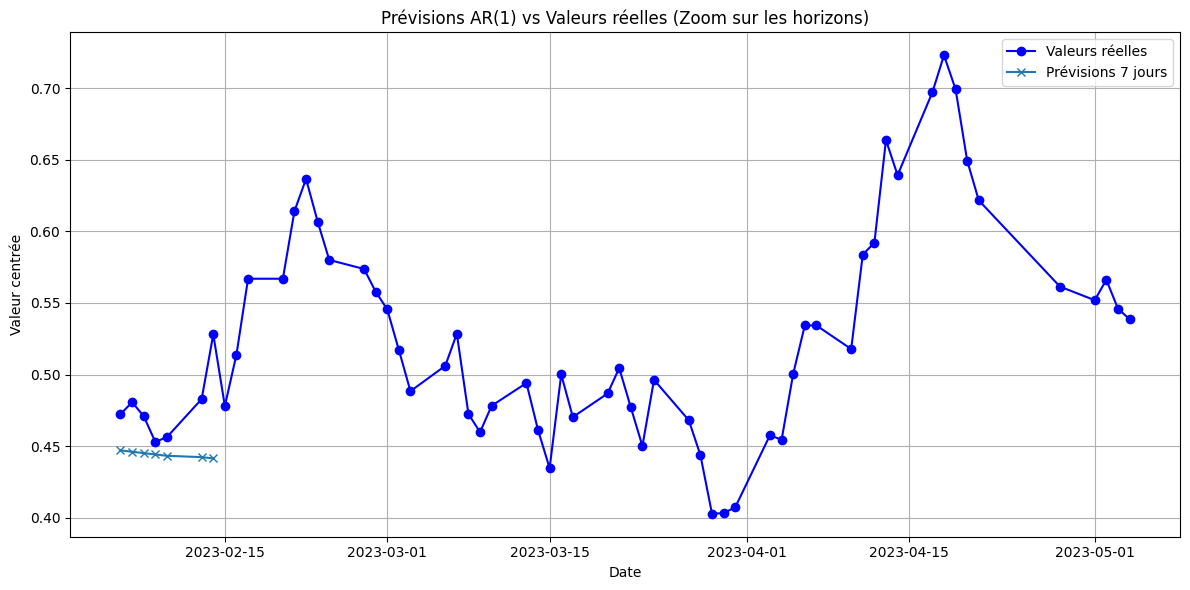

In [28]:
# Tracer les prévisions et les valeurs réelles
plt.figure(figsize=(12, 6))

# Valeurs réelles
plt.plot(data_test['date'].iloc[:max(forecast_horizons)], 
         data_test['value_cent'].iloc[:max(forecast_horizons)], 
         label='Valeurs réelles', color='blue', marker='o')

# Prévisions pour chaque horizon
for horizon in [7]:
    plt.plot(data_test['date'].iloc[:horizon], 
             forecasts[horizon], 
             label=f'Prévisions {horizon} jours', marker='x')

# Ajouter des détails au graphique
plt.title("Prévisions AR(1) vs Valeurs réelles (Zoom sur les horizons)")
plt.xlabel("Date")
plt.ylabel("Valeur centrée")
plt.legend()
plt.grid()
plt.tight_layout()

# Afficher le graphique
plt.show()

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as mse
from statsmodels.tsa.arima.model import ARIMA

# Modèles à tester
models = {
    'AR(1)': (1, 0, 0),
    'ARMA(1,1)': (1, 0, 1),
    'ARMA(1,1) sur Xt': (1, 1, 1)
}

for model_name, order in models.items():
    # Ajustement du modèle
    model = ARIMA(data['value'], order=order)
    fitted_model = model.fit()
    
    # Affichage du résumé du modèle
    print(f"\nModèle {model_name}")
    print(fitted_model.summary())

C:\Users\tapri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Modèle AR(1)
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                18247
Model:                 ARIMA(1, 0, 0)   Log Likelihood               42404.193
Date:                Tue, 01 Apr 2025   AIC                         -84802.387
Time:                        20:25:52   BIC                         -84778.951
Sample:                             0   HQIC                        -84794.685
                              - 18247                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2877      0.168      7.643      0.000       0.958       1.618
ar.L1          0.9988      0.000   3426.321      0.000       0.998       0.999
sigma2         0.0006   1.84e-06    30

In [ ]:

# Prévisions et évaluation
forecast_steps = len(test_data)
results = {}

for model_name, order in models.items():
    # Ajustement du modèle
    model = sm.tsa.ARIMA(train_data, order=order)
    fitted_model = model.fit()
    
    # Prévisions
    forecast = fitted_model.forecast(steps=forecast_steps)
    forecast_index = pd.date_range(start=test_data.index[0], periods=forecast_steps, freq='D')
    forecast = pd.Series(forecast, index=forecast_index)
    
    # Calcul du MSE
    mse = mean_squared_error(test_data, forecast)
    
    # Stockage des résultats
    results[model_name] = {
        'model': fitted_model,
        'forecast': forecast,
        'mse': mse
    }
    
    # Affichage des coefficients estimés
    print(f"\nModèle {model_name}")
    print(f"Coefficients estimés :\n{fitted_model.params}")
    print(f"MSE : {mse:.4f}")

# Visualisation des prévisions
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['value_cent'], label='Valeurs réelles', color='blue')

for model_name, result in results.items():
    plt.plot(result['forecast'].index, result['forecast'], label=f'Prévisions {model_name}')

# Personnalisation du graphique
plt.title("Prévisions ARIMA sur la période de test")
plt.xlabel("Date")
plt.ylabel("Valeur centrée")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


# Conseils supplémentaires
Validation croisée ou séparation train/test : Pour mieux évaluer la performance, sépare une partie finale de tes données comme “jeu de test”. Ajuste le modèle sur le “jeu d’entraînement” seulement, puis compare les prédictions avec le “jeu de test” réel.
